In [1]:
import pandas as pd
import numpy as np
import tqdm
import json
import matplotlib.pyplot as plt
import dataclasses

tqdm.tqdm.pandas()
plt.style.use("ggplot")

In [2]:
df = pd.read_json("./data/preprocessed/preprocessed.json", orient="index")
with open("./data/preprocessed/param.json", "r") as f:
    params = json.load(f)

In [3]:
df.head()

,valid_train_purchased_items,valid_eval_purchased_items,test_train_purchased_items,test_eval_purchased_items,valid_train_recommended_items,valid_eval_recommended_items,test_train_recommended_items,test_eval_recommended_items
0,"[0, 1538, 515, 1029, 525, 1038, 1554, 1044, 53...","[740, 106, 657, 755, 986, 635]","[0, 1538, 515, 1029, 525, 1038, 1554, 1044, 53...","[899, 261, 139, 1419, 657, 1426, 1428, 533, 79...","[1, 2, 3, 4, 5, 6, 8, 10, 11, 14, 16, 17, 20, ...","[1024, 1029, 1041, 1047, 24, 25, 36, 39, 1069,...","[1, 2, 3, 4, 5, 6, 8, 10, 11, 14, 16, 17, 20, ...","[1026, 4, 1029, 5, 1039, 1042, 1043, 20, 1044,..."
1,"[11, 14, 24, 25, 29, 31, 36, 37, 41, 43, 61, 6...","[1664, 261, 1419, 782, 1550, 1038, 785, 1554, ...","[11, 14, 24, 25, 29, 31, 36, 37, 41, 43, 61, 6...","[520, 20, 1044, 24, 28, 1054, 542, 36, 562, 10...","[0, 1, 2, 3, 4, 6, 7, 10, 11, 13, 14, 16, 17, ...","[1, 7, 8, 16, 24, 25, 31, 36, 39, 43, 44, 47, ...","[0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 16, 1...","[1029, 1030, 5, 1033, 1034, 1035, 1041, 1042, ..."
2,"[1538, 4, 1541, 389, 1543, 1160, 1292, 1421, 9...","[834, 612, 1541, 842, 1421, 1136, 849, 912, 15...","[1538, 4, 1541, 389, 1543, 1160, 1292, 1421, 9...","[576, 834, 612, 1541, 614, 325, 877, 912, 1136...","[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 14, 15, 16, ...","[1029, 1031, 7, 1033, 8, 1032, 1036, 1039, 16,...","[0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 1...","[0, 6, 10, 11, 12, 16, 20, 21, 23, 25, 31, 34,..."
3,"[0, 3, 517, 5, 1035, 15, 1047, 1050, 1063, 107...","[769, 4, 1425, 790, 1431, 1195, 1078, 1208, 19...","[0, 3, 4, 517, 5, 1035, 15, 1047, 1050, 1063, ...","[1152, 128, 1416, 268, 1425, 1426, 1183, 1317,...","[0, 1, 2, 3, 6, 7, 13, 14, 16, 17, 18, 20, 21,...","[1028, 1029, 7, 1048, 24, 1052, 1054, 32, 1056...","[0, 1, 2, 3, 6, 7, 13, 14, 16, 17, 18, 20, 21,...","[1029, 10, 1039, 1042, 20, 21, 1044, 1048, 24,..."
4,"[640, 771, 4, 774, 646, 9, 783, 657, 1042, 142...","[832, 834, 771, 1060, 1125, 710, 966, 840, 157...","[4, 9, 1550, 1042, 1564, 1570, 1060, 1573, 157...",None,"[0, 1, 2, 3, 4, 6, 7, 9, 10, 14, 16, 17, 19, 2...","[512, 1024, 1536, 515, 1527, 1029, 518, 1031, ...","[0, 1, 2, 3, 4, 6, 7, 9, 10, 14, 16, 17, 19, 2...",[]


In [4]:
params

{'user_n': 452, 'item_n': 1669}

In [5]:
EPS = 1e-8

@dataclasses.dataclass
class Args:
    mode: str = "valid"
    sampling: str = "ulrmf"
    seed: int = 0
    alpha: float = 0.6
    gamma_p: float = 0.2
    gamma_r: float = 0.5
    eta: float = 1e-2
    lmda: float = 1e-2
    d: int = 100
    batch_size: int = 1
    epochs: int = 5_000_000
    step_size: int = 10_000

USER_N = params["user_n"]
ITEM_N = params["item_n"]

print(f"user_n = {USER_N}, item_n = {ITEM_N}")

user_n = 452, item_n = 1669


In [6]:
df_dict = df.to_dict(orient="index")

df_set = df.copy()
for col in df.columns:
    df_set[col] = df_set[col].apply(lambda x: set() if x is None else set(x))

df_set_dict = df_set.to_dict(orient="index")

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sample_rmf(rnd: np.random.RandomState, args: Args) -> tuple[int, int, int]:
    C_P = 0
    C_NP = 1
    u = rnd.randint(0, USER_N)
    C = rnd.choice([C_P, C_NP], p=[args.gamma_p, 1 - args.gamma_p])

    if C == C_P:
        r_ui = 1
        i = rnd.choice(df_dict[u][f"{args.mode}_train_purchased_items"])
    else:
        r_ui = 0
        while True:
            i = rnd.randint(0, ITEM_N)
            if i not in df_set_dict[u][f"{args.mode}_train_purchased_items"]:
                break

    return u, i, r_ui


def sample_ulrmf(rnd: np.random.RandomState, args: Args) -> tuple[int, int, int]:
    C_RP = 0
    C_NR_NP = 1
    C_other = 2
    p_C_RP = args.gamma_p * args.gamma_r
    p_C_NR_NP = (1 - args.gamma_p) * (1 - args.gamma_r)
    p_C_other = 1 - p_C_RP - p_C_NR_NP

    u = rnd.randint(0, USER_N)
    C = rnd.choice([C_RP, C_NR_NP, C_other], p=[p_C_RP, p_C_NR_NP, p_C_other])

    if C == C_RP:
        r_ui = 1

        while True:
            i = rnd.choice(df_dict[u][f"{args.mode}_train_purchased_items"])
            if i in df_set_dict[u][f"{args.mode}_train_recommended_items"]:
                break
    elif C == C_NR_NP:
        if rnd.random() <= args.alpha:
            r_ui = 1
        else:
            r_ui = 0

        while True:
            i = rnd.randint(0, ITEM_N)
            if (
                i not in df_set_dict[u][f"{args.mode}_train_purchased_items"]
                and i not in df_set_dict[u][f"{args.mode}_train_recommended_items"]
            ):
                break
    else:
        r_ui = 0

        while True:
            i = rnd.randint(0, ITEM_N)
            if (
                i in df_set_dict[u][f"{args.mode}_train_purchased_items"]
                and i not in df_set_dict[u][f"{args.mode}_train_recommended_items"]
            ) or (
                i not in df_set_dict[u][f"{args.mode}_train_purchased_items"]
                and i in df_set_dict[u][f"{args.mode}_train_recommended_items"]
            ):
                break

    return u, i, r_ui


def eval(X_u: np.ndarray, X_v: np.ndarray, k: int, args: Args) -> tuple[float, float]:
    acc = 0
    uplift = 0
    target_user_n = 0

    for u in range(USER_N):
        if df_dict[u][f"{args.mode}_eval_purchased_items"] is None:
            continue
        L_M = set(np.matmul(X_u[u], X_v.T).argsort()[-k:])
        L_D = set(df_dict[u][f"{args.mode}_eval_recommended_items"])
        L_M_and_D = list(L_M & L_D)
        L_M_not_D = list(L_M - L_D)

        Y = set(df_dict[u][f"{args.mode}_eval_purchased_items"])

        if len(L_M_and_D) > 0 and len(L_M_not_D) > 0:
            # print(len(L_M_and_D), len(L_M_not_D), len(L_M), len(L_D))
            tau = sum([1 if e in Y else 0 for e in L_M_and_D]) / len(L_M_and_D) - sum(
                [1 if e in Y else 0 for e in L_M_not_D]
            ) / len(L_M_not_D)
            uplift += tau

            v = len(L_M & Y)
            acc += v

            target_user_n += 1

    accuracy = acc / target_user_n / k
    uplift = uplift / target_user_n

    print(f"Target user N  = {target_user_n}")
    print(f"Accuracy@{k}    = {accuracy}")
    print(f"Uplift@{k}      = {uplift}")

    return accuracy, uplift


def train(args: Args) -> tuple[np.ndarray, np.ndarray, list[float]]:
    rnd = np.random.RandomState(args.seed)
    X_u = rnd.normal(size=(USER_N, args.d))
    X_v = rnd.normal(size=(ITEM_N, args.d))

    losses = []

    for t in range(args.epochs):
        if args.sampling == "ulrmf":
            u, i, r_ui = sample_ulrmf(rnd=rnd, args=args)
        elif args.sampling == "rmf":
            u, i, r_ui = sample_rmf(rnd=rnd, args=args)
        else:
            assert False

        x_ui = sigmoid(np.dot(X_u[u], X_v[i]))

        X_u[u] -= args.eta * ((x_ui - r_ui) * X_v[i] + 2 * args.lmda * X_u[u])
        X_v[i] -= args.eta * ((x_ui - r_ui) * X_u[u] + 2 * args.lmda * X_v[i])

        L = -(r_ui * np.log(max(EPS, x_ui)) + (1 - r_ui) * np.log(max(EPS, 1 - x_ui)))
        losses.append(L)

        if (t + 1) % args.step_size == 0:
            print(
                f"[{t+1:8}/{args.epochs}] {sum(losses[-args.step_size:]) / args.step_size:.5}",
                end="\r",
            )

    return X_u, X_v, losses

In [8]:
# X_u, X_v, losses = train(args)

# plt.plot([sum(losses[i : i + args.step_size]) / args.step_size for i in range(args.step_size, args.epochs, args.step_size)])
# plt.xlabel("epoch")
# plt.ylabel("loss")

In [9]:
k = 30

alphas = np.linspace(0.0, 1.0, 6)
accuracys, uplifts = [], []

for alpha in alphas:
    args = Args()
    args.alpha = alpha
    X_u, X_v, losses = train(args=args)
    accuracy, uplift = eval(X_u=X_u, X_v=X_v, k=k, args=args)
    accuracys.append(accuracy)
    uplifts.append(uplift)

Target user N  = 420.24106
Accuracy@30    = 0.11761904761904761
Uplift@30      = 0.0368918601660703
Target user N  = 420.43672
Accuracy@30    = 0.118015873015873
Uplift@30      = 0.03534580815132853
Target user N  = 417.53687
Accuracy@30    = 0.10991207034372502
Uplift@30      = 0.053377121834915074
Target user N  = 413.58743
Accuracy@30    = 0.07756255044390638
Uplift@30      = 0.08177753667552623
Target user N  = 400.58005
Accuracy@30    = 0.03991666666666667
Uplift@30      = 0.07283946684531287
Target user N  = 364.52072
Accuracy@30    = 0.01391941391941392
Uplift@30      = 0.038384559275583534


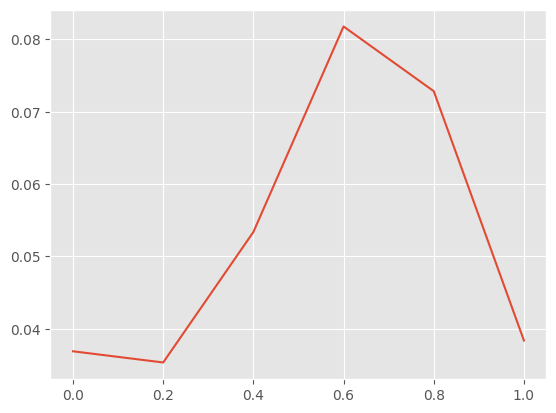

In [12]:
plt.plot(alphas, uplifts)

In [11]:
# np.save("./model/ulrmf_X_u.npy", X_u)
# np.save("./model/ulrmf_X_v.npy", X_v)

# X_u = np.load("./model/ulrmf_X_u.npy")
# X_v = np.load("./model/ulrmf_X_v.npy")

# np.save("./model/rmf_X_u.npy", X_u)
# np.save("./model/rmf_X_v.npy", X_v)

# X_u = np.load("./model/rmf_X_u.npy")
# X_v = np.load("./model/rmf_X_v.npy")

$$
-(r_{ui} \log \sigma (\hat{x}_{ui}) + (1 - r_{ui}) \log (1 - \sigma (\hat{x}_{ui})))
$$